In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

In [3]:
train = pd.read_csv("data/preprocessing/train.csv")
val   = pd.read_csv("data/preprocessing/val.csv")
test  = pd.read_csv("data/preprocessing/test.csv")

for df in [train, val, test]:
    df["text"] = (df["subject"].astype(str) + " " + df["body"].astype(str)).str.strip()

Xtr, ytr = train["text"], train["label"]
Xva, yva = val["text"], val["label"]
Xte, yte = test["text"], test["label"]

print("Loaded splits successfully:")
print(f"Train: {len(Xtr)}, Val: {len(Xva)}, Test: {len(Xte)}")

Loaded splits successfully:
Train: 57325, Val: 12284, Test: 12284


In [4]:
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1,2),      # unigrams + bigrams
        min_df=2,
        max_features=100_000,
        stop_words="english"
    )),
    ("lr", LogisticRegression(
        max_iter=1000,
        C=1.0,
        class_weight="balanced"
    ))
])

In [5]:
pipe.fit(Xtr, ytr)

# Validation
val_pred = pipe.predict(Xva)
print("Validation F1:", f1_score(yva, val_pred))
print(classification_report(yva, val_pred, digits=3))

Validation F1: 0.9881324172392255
              precision    recall  f1-score   support

           0      0.989     0.986     0.987      5889
           1      0.987     0.990     0.988      6395

    accuracy                          0.988     12284
   macro avg      0.988     0.988     0.988     12284
weighted avg      0.988     0.988     0.988     12284



In [6]:
grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__max_features": [50_000, 100_000],
    "lr__C": [0.1, 1, 10]
}
gs = GridSearchCV(pipe, grid, scoring="f1", n_jobs=-1, cv=3, verbose=1)
gs.fit(Xtr, ytr)
print("Best:", gs.best_params_, gs.best_score_)
pipe = gs.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best: {'lr__C': 10, 'tfidf__max_features': 100000, 'tfidf__ngram_range': (1, 2)} 0.9880669265152093


In [7]:
pred_test = pipe.predict(Xte)
print("Test F1:", f1_score(yte, pred_test))
print(classification_report(yte, pred_test, digits=3))

Test F1: 0.9905564660891282
              precision    recall  f1-score   support

           0      0.992     0.988     0.990      5890
           1      0.989     0.992     0.991      6394

    accuracy                          0.990     12284
   macro avg      0.990     0.990     0.990     12284
weighted avg      0.990     0.990     0.990     12284



In [15]:
#ensures we have probabilities and predictions for the test set
if "test_prob" not in globals():
    #LogisticRegression supports both predict_proba and decision_function
    test_prob = pipe.predict_proba(Xte)[:, 1]

if "pred_test" not in globals():
    pred_test = (test_prob >= 0.5).astype(int)  # or keep your tuned threshold if you used one

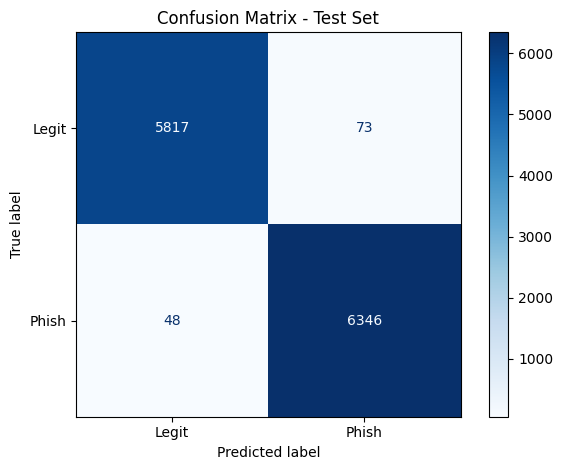

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(yte, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit", "Phish"])
disp.plot(values_format="d", cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()

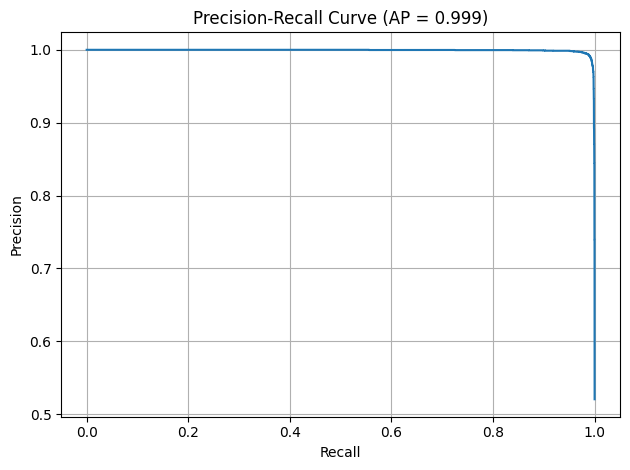

In [17]:
prec, rec, _ = precision_recall_curve(yte, test_prob)
ap = average_precision_score(yte, test_prob)

plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AP = {ap:.3f})")
plt.grid(True)
plt.tight_layout()
plt.show()

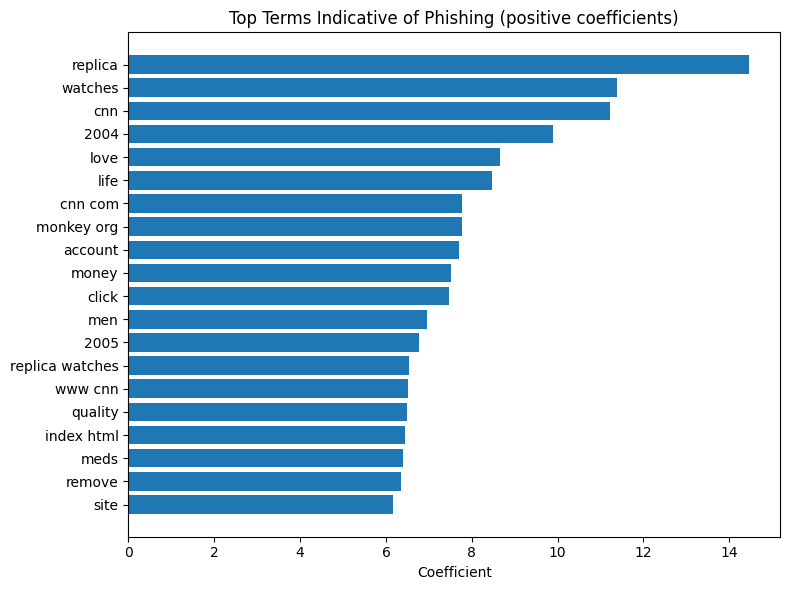

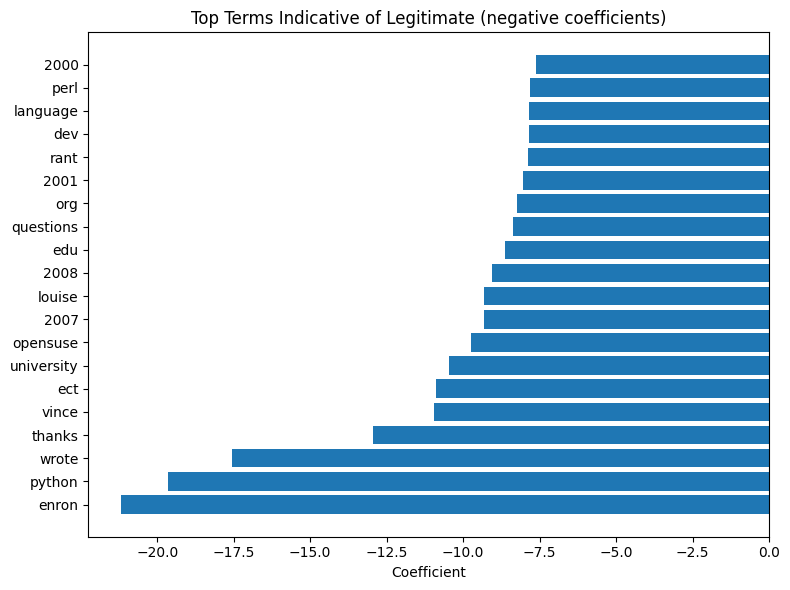

In [18]:
#grabs feature names from the fitted TfidfVectorizer inside the pipeline
tfidf = pipe.named_steps["tfidf"]
lr    = pipe.named_steps["lr"]

feature_names = tfidf.get_feature_names_out()
coefs = lr.coef_[0]

def plot_top_terms(coefs, feature_names, top_n=20, title=""):
    idx = np.argsort(coefs)[-top_n:]
    terms = feature_names[idx]
    vals  = coefs[idx]

    plt.figure(figsize=(8, 6))
    y = np.arange(top_n)
    plt.barh(y, vals)
    plt.yticks(y, terms)
    plt.xlabel("Coefficient")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_bottom_terms(coefs, feature_names, top_n=20, title=""):
    idx = np.argsort(coefs)[:top_n]
    terms = feature_names[idx]
    vals  = coefs[idx]

    plt.figure(figsize=(8, 6))
    y = np.arange(top_n)
    plt.barh(y, vals)
    plt.yticks(y, terms)
    plt.xlabel("Coefficient")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_top_terms(coefs, feature_names, top_n=20, title="Top Terms Indicative of Phishing (positive coefficients)")
plot_bottom_terms(coefs, feature_names, top_n=20, title="Top Terms Indicative of Legitimate (negative coefficients)")

In [19]:
summary = pd.DataFrame({
    "Split": ["Test"],
    "Accuracy": [accuracy_score(yte, pred_test)],
    "Precision": [precision_score(yte, pred_test)],
    "Recall": [recall_score(yte, pred_test)],
    "F1": [f1_score(yte, pred_test)],
    "PR-AUC": [average_precision_score(yte, test_prob)]
})

summary.round(3)

,Split,Accuracy,Precision,Recall,F1,PR-AUC
0,Test,0.99,0.989,0.992,0.991,0.999


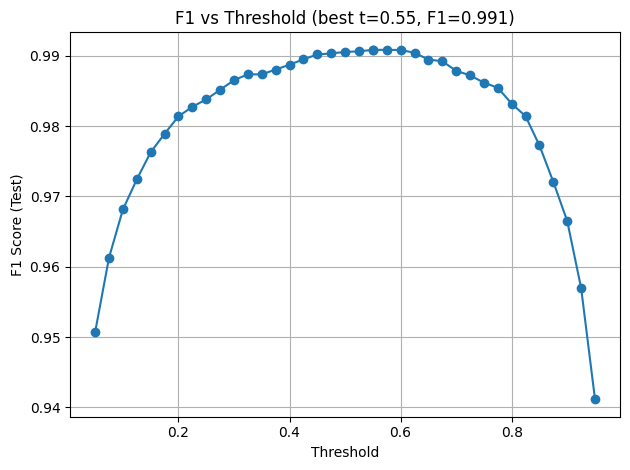

In [20]:
ths = np.linspace(0.05, 0.95, 37)
f1s = [f1_score(yte, (test_prob >= t).astype(int)) for t in ths]

plt.figure()
plt.plot(ths, f1s, marker="o")
plt.xlabel("Threshold")
plt.ylabel("F1 Score (Test)")
best_i = int(np.argmax(f1s))
plt.scatter([ths[best_i]], [f1s[best_i]])
plt.title(f"F1 vs Threshold (best t={ths[best_i]:.2f}, F1={f1s[best_i]:.3f})")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
import joblib, json
from pathlib import Path

Path("models").mkdir(exist_ok=True)
joblib.dump(pipe, "models/tfidf_logreg.joblib")

#if we later decided on a tuned threshold, will set it here; otherwise keep 0.5 because F1 is extremely good now
chosen_threshold = 0.5
(Path("models") / "threshold.txt").write_text(str(chosen_threshold))

#saves a small metrics json
metrics = {
    "test": {
        "accuracy": float(accuracy_score(yte, pred_test)),
        "precision": float(precision_score(yte, pred_test)),
        "recall": float(recall_score(yte, pred_test)),
        "f1": float(f1_score(yte, pred_test)),
        "pr_auc": float(average_precision_score(yte, test_prob)),
    }
}
Path("results").mkdir(exist_ok=True)
(Path("results") / "baseline_metrics.json").write_text(json.dumps(metrics, indent=2))

print("Saved: models/tfidf_logreg.joblib, models/threshold.txt, results/baseline_metrics.json")

Saved: models/tfidf_logreg.joblib, models/threshold.txt, results/baseline_metrics.json
